## BtnkMAE Demo
This demo is modified from the original MAE repository by Meta AI ([GitHub Repository](https://github.com/facebookresearch/mae)) to visualize our pretraiend BtnkMAE.
### Check whether run in Colab

In [11]:
import os, sys, torch
import requests
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
    !git clone https://github.com/grasp-lyrl/btnk_mae.git
    sys.path.append('./btnk_mae')
else:
    sys.path.append('..')

IN_MEAN = np.array([0.485, 0.456, 0.406])
IN_STD = np.array([0.229, 0.224, 0.225])

# Process 224x224 images
## Load BtnkMAE Encoder and Decoder

In [12]:
# Download the checkpoint if not exists
checkpoint_name = "btnk_mae_vit_base_224.pth"  # "btnk_mae_vit_large_relu_224.pth" / "btnk_mae_vit_base_224.pth"
checkpoint_url = f"https://huggingface.co/zhaozewang56/btnk_mae/resolve/main/{checkpoint_name}"
!wget -nc -L {checkpoint_url}

File ‘btnk_mae_vit_base_224.pth’ already there; not retrieving.



In [13]:
from btnk_mae import BtnkMAEEncoder, BtnkMAEDecoder
from btnk_mae.utils.patchify import unpatchify

# Determine the model size and activation function
model_size_split = checkpoint_name.split('_')[3]
if model_size_split in ['base', 'large']:
    model_size = model_size_split
else:
    raise ValueError(f"Unknown model_size '{model_size_split}' in checkpoint_name '{checkpoint_name}'")
act_fn = "relu" if checkpoint_name.split('_')[4] == "relu" else None

# Load the encoder and decoder
encoder = BtnkMAEEncoder(model_size=model_size, act_fn=act_fn)
decoder = BtnkMAEDecoder(model_size=model_size)
checkpoint = torch.load(checkpoint_name, map_location='cpu', weights_only=False)
encoder.load_state_dict(checkpoint['enc_model'], strict=False)
decoder.load_state_dict(checkpoint['dec_model'], strict=False)

<All keys matched successfully>

## Load the example image
NOTE: the following code is modified from the original MAE repository by Meta AI (https://github.com/facebookresearch/mae/blob/main/demo/mae_visualize.ipynb)


In [14]:
def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * IN_STD + IN_MEAN) * 255, 0, 255).int().cpu().numpy())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def load_image(img_url=None, img_path=None):
    assert img_url is not None or img_path is not None
    if img_url:
        img = Image.open(requests.get(img_url, stream=True).raw)
    else:
        img = Image.open(img_path).convert("RGB")
    img = img.resize((224, 224))
    img = np.array(img) / 255.
    assert img.shape == (224, 224, 3)
    img = img - IN_MEAN
    img = img / IN_STD
    return img

/tmp/ipykernel_1466936/1687184349.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(torch.clip((image * IN_STD + IN_MEAN) * 255, 0, 255).int().cpu().numpy())


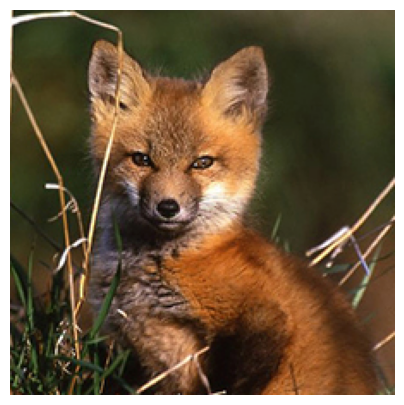

In [15]:
# load an image
img_url = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg' # fox, from ILSVRC2012_val_00046145
# img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851
img = load_image(img_url=img_url)
# img = load_image(img_path='../assets/224x224/img_0.png')  # local image
plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

## Encode and Reconstruct

In [16]:
with torch.no_grad():
    img_tensor = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)  # (1, 3, 224, 224)
    latent = encoder(img_tensor)[:, 0, :]  # (1, 1024) !
    img_patch = decoder(latent)

/tmp/ipykernel_1466936/3746477068.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  rec_img = torch.clamp(rec_img * IN_STD + IN_MEAN, 0, 1)


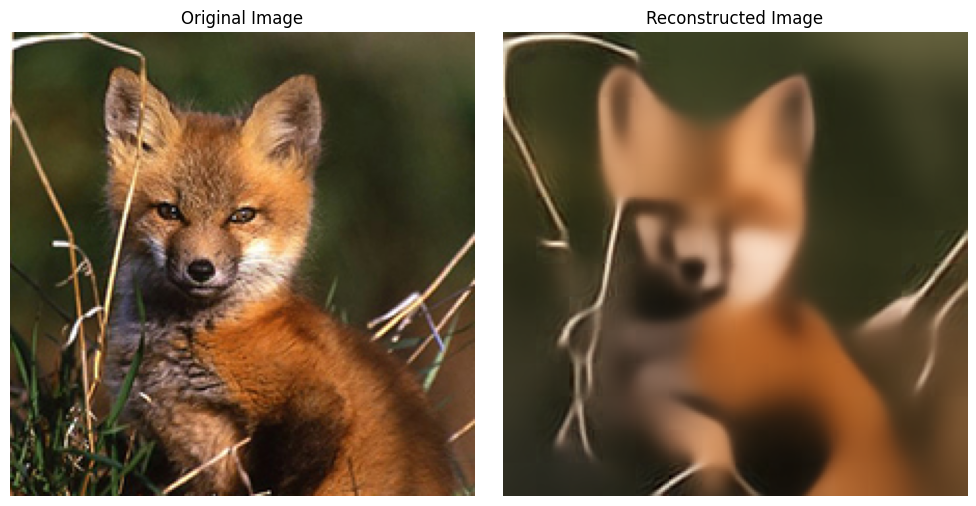

In [17]:
rec_img = unpatchify(img_patch, decoder.patch_size)[0].detach().cpu().permute(1, 2, 0)
rec_img = torch.clamp(rec_img * IN_STD + IN_MEAN, 0, 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img * IN_STD + IN_MEAN)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2) 
plt.imshow(rec_img)
plt.title("Reconstructed Image")
plt.axis('off')
plt.tight_layout()